In [ ]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = "/content/gdrive/MyDrive/images_original"
data_dir = os.path.join(PATH)

BATCH_SIZE = 32
IMG_SIZE = (288, 432)

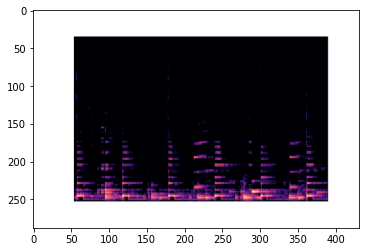

shape of image is: (288, 432, 4)


In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread(PATH+'/blues/blues00093.png')
imgplot = plt.imshow(img)
plt.show()
print('shape of image is:',img.shape)

In [ ]:
batch_size = 8
image_size = 224
train_trms = T.Compose([
T.Resize(image_size),
T.RandomRotation(20),
T.RandomHorizontalFlip(),
T.ToTensor()])
val_trms = T.Compose([
T.Resize(image_size),
T.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = PATH, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = PATH, transform = val_trms)

In [ ]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - (val_size)

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape torch.Size([8, 3, 224, 336])


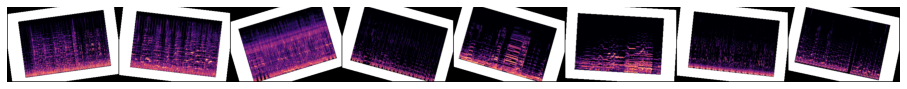

In [ ]:
for images, _ in train_dl:
    print('images.shape',images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break


In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images,targets = batch
    out = self(images)
    loss = F.cross_entropy(out, targets)
    return loss

  def validation_step(self, batch):
    images,targets = batch
    out = self(images)
    loss = F.cross_entropy(out, targets)
    score = accuracy(out, targets)
    return {'val_loss': loss.detach(),'val_score': score.detach() }

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_scores = [x['val_score'] for x in outputs]
    epoch_score = torch.stack(batch_scores).mean()
    return {'val_loss': epoch_loss.item(),'val_score': epoch_score.item() }

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_score{:.4f}".format(epoch, result['val_loss'],result['val_score']))

In [ ]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
  def __init__(self):
    super().__init__()
    # Use a pretrained model
    self.network = models.resnet34(pretrained=True)
    # Replace last layer
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 10)
  def forward(self, xb):
    return self.network(xb)
  def freeze(self):
    for param in self.network.parameters():
      param.require_grad = False
    for param in self.network.fc.parameters():
      param.require_grad = True
  def unfreeze(self):
    for param in self.network.parameters():
      param.require_grad = True

In [ ]:
def evaluate(model,val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  optimizer = opt_func(model.parameters(),max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch = len(train_loader))
  for epoch in range(epochs):
    model.train()
    lrs=[]
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      loss.backward()
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()
    result = evaluate(model, val_loader)
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
def to_device(data, device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model = to_device(Net(), device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
history = [evaluate(model, val_dl)]

In [ ]:
model.freeze()

In [ ]:
epochs = 50
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.3887, val_score0.4762


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.2586, val_score0.5208


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.9833, val_score0.6577


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.1468, val_score0.6399


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.4861, val_score0.4464


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.3741, val_score0.4464


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.2818, val_score0.5774


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.2593, val_score0.5774


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.1468, val_score0.5952


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.1236, val_score0.5655


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.1164, val_score0.6964


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [11], val_loss: 0.9877, val_score0.6280


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [12], val_loss: 0.6908, val_score0.7649


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.1737, val_score0.5863


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [14], val_loss: 0.9611, val_score0.7024


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.0370, val_score0.6845


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [16], val_loss: 0.9982, val_score0.6667


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [17], val_loss: 0.9248, val_score0.6935


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.0148, val_score0.7024


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [19], val_loss: 0.6300, val_score0.7470


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.0502, val_score0.6220


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [21], val_loss: 0.8358, val_score0.7202


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [22], val_loss: 0.8516, val_score0.7649


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [23], val_loss: 0.8960, val_score0.6994


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [24], val_loss: 0.7156, val_score0.8036


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.1208, val_score0.6726


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [26], val_loss: 0.5125, val_score0.8125


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [27], val_loss: 0.7641, val_score0.7857


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [28], val_loss: 0.9669, val_score0.6815


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [29], val_loss: 0.6807, val_score0.7470


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [30], val_loss: 0.6950, val_score0.8214


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [31], val_loss: 0.7166, val_score0.7560


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [32], val_loss: 0.6305, val_score0.8006


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.0087, val_score0.6458


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [34], val_loss: 0.6989, val_score0.7917


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [35], val_loss: 0.6891, val_score0.7917


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [36], val_loss: 0.9620, val_score0.7083


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [37], val_loss: 0.5713, val_score0.7738


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [38], val_loss: 0.7471, val_score0.8006


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [39], val_loss: 0.7472, val_score0.7738


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [40], val_loss: 0.7305, val_score0.8006


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [41], val_loss: 0.6689, val_score0.7827


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [42], val_loss: 0.6434, val_score0.7649


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [43], val_loss: 0.7017, val_score0.8095


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [44], val_loss: 0.6954, val_score0.7827


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [45], val_loss: 0.6420, val_score0.7738


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [46], val_loss: 0.6616, val_score0.7827


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [47], val_loss: 0.6878, val_score0.7917


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [48], val_loss: 0.6148, val_score0.8095


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch [49], val_loss: 0.5880, val_score0.8274
CPU times: user 5min 9s, sys: 1min 30s, total: 6min 39s
Wall time: 9min 30s
